In [53]:
import torch
import torchvision
import torch.nn as nn


In [54]:
torch.cuda.is_available()

True

In [55]:
batch_size=512

In [56]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [57]:
train = torchvision.datasets.CIFAR10('cifar', train=True, download=True,  transform=torchvision.transforms.Compose([
                torchvision.transforms.Resize((32, 32)),
                torchvision.transforms.ToTensor(), 
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]))

Files already downloaded and verified


In [58]:
test = torchvision.datasets.CIFAR10('cifar',
        train=False, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]))

Files already downloaded and verified


In [59]:
train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [60]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample = None, stride=1) -> None:
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.identity_downsample = identity_downsample
        

    def forward(self, x):
        start_val = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            start_val = self.identity_downsample(start_val)
        x = x + start_val
        x = self.activation(x)
        return x

class ResNet(nn.Module):
    def __init__(self) -> None:
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(512, 10)

        self.layer1 = self.make_layer(64, 64, stride=1)
        self.layer2 = self.make_layer(64, 128, stride=2)
        self.layer3 = self.make_layer(128, 256, stride=2)
        self.layer4 = self.make_layer(256, 512, stride=2)
        

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.maxpool2(x)
        x = self.layer2(x)
        x = self.maxpool2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x
    
    def make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            ResBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResBlock(out_channels, out_channels)
        )

    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )



In [61]:
import matplotlib.pyplot as plt
def draw_curve(current_epoch):
    #if device == f'cuda:{device_id}':
    #    y_err = y_err.cpu()
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig('train.jpg')

1.3083785033416748
1.0244948863983154
epoch: 1, loss: 1.0244948863983154, acc: 0.6110778443113772, acc2: 0.6123000000000001
0.8784712671470642
0.8222231268882751
epoch: 2, loss: 0.8222231268882751, acc: 0.653692614770459, acc2: 0.655
0.6293735150718689
0.6844152808189392
epoch: 3, loss: 0.6844152808189392, acc: 0.6792415169660678, acc2: 0.6806
0.40516197229385376
0.4077182412147522
epoch: 4, loss: 0.4077182412147522, acc: 0.6713572854291417, acc2: 0.6727000000000001
0.24662737726211548
0.338722288608551
epoch: 5, loss: 0.338722288608551, acc: 0.6543912175648703, acc2: 0.6557000000000001
0.1408475833415985
0.211715430021286
epoch: 6, loss: 0.211715430021286, acc: 0.6550898203592814, acc2: 0.6564
0.09664018417358398
0.13313031196594238
epoch: 7, loss: 0.13313031196594238, acc: 0.6687624750499002, acc2: 0.6701


KeyboardInterrupt: 

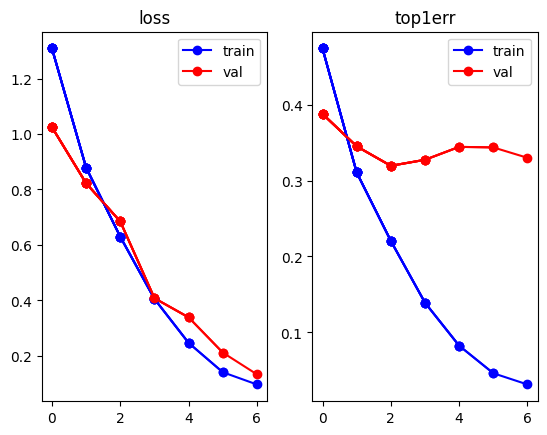

In [62]:
model = ResNet()
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3) # 0,001
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, verbose=True)

loss_list = []
acc_list = []

x_epoch = []
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")

for epoch in range(100):
  # optimizer = optim_scheduler(epoch)
  running_loss = 0
  running_corrects = 0
  for idx, (x, label) in enumerate(train):
    x, label = x.to(device), label.to(device)

    model.train()

    optimizer.zero_grad()

    outputs = model(x)
    loss = criterion(outputs, label)
    _, preds = torch.max(outputs, 1)
    
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item() * x.size(0)
    running_corrects += torch.sum(preds == label.data)
  
  train_loss = running_loss / len(train.dataset)
  print(train_loss)
  epoch_acc = (running_corrects.double() / len(train.dataset)).cpu()
  y_loss['train'].append(train_loss)
  y_err['train'].append(1.0 - epoch_acc)

  model.eval()
  with torch.no_grad():
    lr_scheduler.step(train_loss)
    tot_corr = 0
    tot_num = len(test)
      
    # epoch_acc = running_corrects.double() / len(test.dataset)
    running_loss = 0
    running_corrects = 0
    for x, label in test:
      x, label = x.to(device), label.to(device)
      outputs = model(x)
      pred = outputs.argmax(dim=1)
      _, preds = torch.max(outputs, 1)
      
      # loss.backward()

      running_loss += loss.item() * x.size(0)
      running_corrects += torch.sum(preds == label.data)
      tot_corr += torch.eq(pred, label).double().sum().item() # using item() to convert tensor to number
      tot_num += x.size(0)
    epoch_acc = (running_corrects.double() / len(test.dataset)).cpu()
    acc = tot_corr / tot_num
  test_loss = running_loss / len(test.dataset)
  loss_list.append(loss.item())
  acc_list.append(acc)
  print(test_loss)
  y_loss['val'].append(test_loss)
  y_err['val'].append(1.0 - epoch_acc)
  draw_curve(epoch)
    
  print(f'epoch: {epoch+1}, loss: {loss}, acc: {acc}, acc2: {epoch_acc}')

In [ ]:
torch.cuda.empty_cache()

model = ResNet()
model.to(device)
next(model.parameters()).is_cuda

epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

import time
import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                # inputs = torch.transforms.functional.resize(inputs, (112, 112))
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train': # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

model, _ = train_model(model, {"train": train, "val": test}, criterion, optimizer, epochs)